In [1]:
import sys
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMMPA
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import SaltRemover

In [2]:
print(rdBase.rdkitVersion)

2018.09.2


In [3]:
mmpapath = os.path.join(RDConfig.RDContribDir, 'mmpa')
sys.path.append(mmpapath)

In [4]:
df = pd.read_csv('Chembl_FXa.txt', sep='\t')
df.head(2)

,CMPD_CHEMBLID,MOLREGNO,PARENT_CMPD_CHEMBLID,PARENT_MOLREGNO,MOL_PREF_NAME,COMPOUND_KEY,MOLWEIGHT,ALOGP,PSA,NUM_RO5_VIOLATIONS,...,JOURNAL,YEAR,VOLUME,ISSUE,FIRST_PAGE,CELL_ID,CELL_CHEMBL_ID,CELL_NAME,ACTIVITY_PARAMS,ACTIVITY_PROPS
0,CHEMBL503584,523011,CHEMBL503584,523011,NaN,36aq,554.60,4.73,178.74,2.0,...,Bioorg. Med. Chem.,2009.0,17.0,11.0,3934.0,NaN,NaN,NaN,NaN,NaN
1,CHEMBL364284,328609,CHEMBL364284,328609,NaN,328609,453.88,2.66,88.18,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
remover = SaltRemover.SaltRemover()

In [6]:
mols = []
for i, smi in enumerate(df.CANONICAL_SMILES):
    try:
        mol = Chem.MolFromSmiles(smi)
        mol.SetProp('CMPD_CHEMBLID', df.CMPD_CHEMBLID[i])
        mol = remover.StripMol(mol)
        mols.append(mol)
    except:
        print(smi)

nan
nan


In [7]:
len(mols)

3354

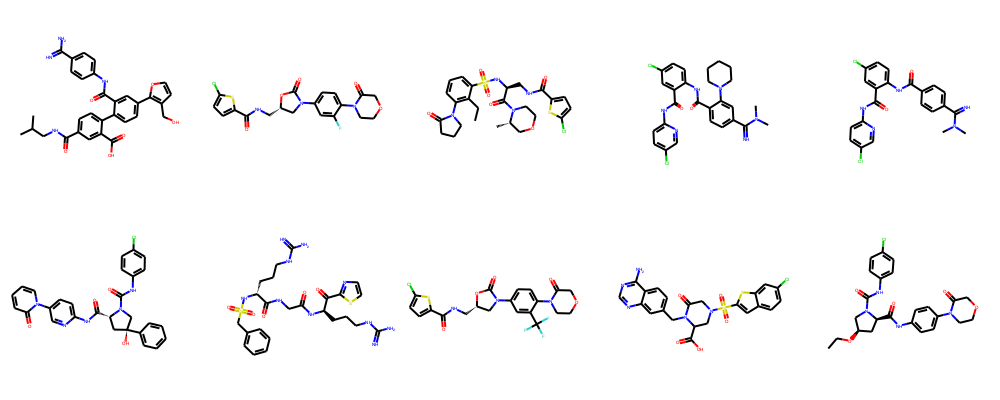

In [8]:
Draw.MolsToGridImage(mols[:10], molsPerRow=5)

In [9]:
import rfrag

In [ ]:
rfragdata = []
for i, smi in enumerate(df.CANONICAL_SMILES):
    try:
        out = rfrag.fragment_mol(smi, df.CMPD_CHEMBLID[i])
        rfragdata.append(out)
    except:
        print(smi, df.CMPD_CHEMBLID[i])

nan CHEMBL3917628
nan CHEMBL3917628


In [ ]:
len(rfragdata)

3354

In [ ]:
from collections import namedtuple
 
Frag = namedtuple( 'Frag', ['id', 'scaffold', 'rgroup'] )
 
class Series():
    def __init__( self ):
        self.rgroups = []
        self.scaffold = ""

def getFrags(rfrags):
    frags = []
    for lines in rfrags:
        for line in lines:
            broken = line.rstrip().split(",")
            if broken[2]: # single cut
                continue
            smiles = broken[-1].split(".")
            mols = [Chem.MolFromSmiles( smi ) for smi in smiles]
            numAtoms = [mol.GetNumAtoms() for mol in mols]
            if len(numAtoms) < 2:
                continue
            if numAtoms[0] > 5 and numAtoms[1] < 12:
                frags.append(Frag(broken[1], smiles[0], smiles[1]))
            if numAtoms[1] > 5 and numAtoms[0] < 12:
                frags.append(Frag(broken[1], smiles[1], smiles[0]))
    frags.sort(key=lambda x:(x.scaffold, x.rgroup))
    return frags
 
def getSeries(frags):
    oldfrag = Frag(None, None, None)
    series = Series()
    for frag in frags:
        if frag.scaffold != oldfrag.scaffold:
            if len(series.rgroups) >= 2:
                series.scaffold = oldfrag.scaffold
                yield series
            series = Series()
        series.rgroups.append((frag.rgroup, frag.id))
        oldfrag = frag
    if len(series.rgroups) >= 2:
        series.scaffold = oldfrag.scaffold
        yield series

In [ ]:
frags = getFrags(rfragdata)

In [ ]:
series = getSeries(frags)

In [ ]:
series =[i for i in series]

In [ ]:
len(series)

In [ ]:
from IPython.display import display

In [ ]:
for s in series[:50]:
    mols = [Chem.MolFromSmiles(s.scaffold)]
    ids = ['scaffold']
    for r in s.rgroups:
        rg = Chem.MolFromSmiles(r[0])
        mols.append(rg)
        ids.append(r[1])
    if len(mols) > 5:
        display(Draw.MolsToGridImage(mols, molsPerRow=5, legends=ids))
        print("########")